# ==========================================
# 1. Imports & Configuration
# ==========================================

In [11]:
# ==============================================================================
# 03_model_training.ipynb — NSL-KDD (Integrated with 01/02, High-Recall Binary)
# ==============================================================================
# This notebook assumes 02_preprocessing_FIXED.ipynb produced:
#   data/processed/train_cleaned.csv
#   data/processed/test_cleaned.csv
#
# Responsibilities of THIS notebook:
#   - Build preprocessing pipeline (log1p+RobustScaler + OHE)
#   - Train Binary IDS model (Attack vs Normal) + choose threshold on a dedicated set
#   - Train Multi-class model on attacks only (DoS/Probe/R2L/U2R)
#   - Save artifacts for dashboard/usage
# ==============================================================================

from __future__ import annotations

import json
import time
import copy
import joblib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300

RANDOM_STATE = 42

# --- Configuration ---


In [12]:
# ----------------------------------------------------------------------
# Paths & Setup
# ----------------------------------------------------------------------
def get_project_root() -> Path:
    cwd = Path.cwd().resolve()
    return cwd.parent if cwd.name.lower() == "notebooks" else cwd

PROJECT_ROOT = get_project_root()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
FIGURES_DIR = RESULTS_DIR / "figures"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"[✓] Project Root: {PROJECT_ROOT}")
print(f"[✓] Processed Dir: {PROCESSED_DIR}")

[✓] Project Root: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection
[✓] Processed Dir: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\data\processed



# ==========================================
# 2. Load Preprocessed Data
# ==========================================

In [13]:
# ----------------------------------------------------------------------
# Load Preprocessed CSVs (produced by notebook 02)
# ----------------------------------------------------------------------
train_path = PROCESSED_DIR / "train_cleaned.csv"
test_path  = PROCESSED_DIR / "test_cleaned.csv"

if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError(
        "Missing processed CSVs. Run 02_preprocessing_FIXED.ipynb first.\n"
        f"Expected:\n- {train_path}\n- {test_path}"
    )

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(f"[✓] Loaded train={train_df.shape}, test={test_df.shape}")

# Expect these columns from notebook 02. If you changed names there, update here.
REQ_COLS = ["binary_target", "attack_class"]
missing = [c for c in REQ_COLS if c not in train_df.columns or c not in test_df.columns]
if missing:
    raise ValueError(
        f"Processed CSVs are missing required columns: {missing}. "
        "Make sure notebook 02 creates them."
    )

print("[✓] Required label columns exist.")
print("Train binary distribution:", dict(pd.Series(train_df["binary_target"]).value_counts().sort_index()))
print("Test  binary distribution:", dict(pd.Series(test_df["binary_target"]).value_counts().sort_index()))

[✓] Loaded train=(125973, 45), test=(22544, 45)
[✓] Required label columns exist.
Train binary distribution: {0: np.int64(67343), 1: np.int64(58630)}
Test  binary distribution: {0: np.int64(9711), 1: np.int64(12833)}



# ==========================================
# 3. Evaluation Helper Function
# ==========================================

In [14]:
# ----------------------------------------------------------------------
# Feature preparation (locked schema)
# ----------------------------------------------------------------------
DROP_COLS = ["label", "attack_class", "binary_target", "attack_category", "level", "id", "difficulty"]

X_train_full = train_df.drop(columns=DROP_COLS, errors="ignore")
X_test_full  = test_df.drop(columns=DROP_COLS, errors="ignore")

# Lock schema between train & test
FEATURE_COLUMNS = sorted(set(X_train_full.columns).union(set(X_test_full.columns)))
X_train_full = X_train_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)
X_test_full  = X_test_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)

y_train_bin = train_df["binary_target"].astype(int).values
y_test_bin  = test_df["binary_target"].astype(int).values

print(f"[✓] Schema Locked: {len(FEATURE_COLUMNS)} features.")

[✓] Schema Locked: 41 features.



# ==========================================
# 4. Training Binary Models (Detection)
# ==========================================

In [15]:
# ----------------------------------------------------------------------
# Preprocessing pipeline
# ----------------------------------------------------------------------
CAT_COLS = [c for c in ["protocol_type", "service", "flag"] if c in FEATURE_COLUMNS]
NUM_COLS = [c for c in FEATURE_COLUMNS if c not in CAT_COLS]
LOG_COLS = ["src_bytes", "dst_bytes", "duration", "hot", "num_compromised"]

def safe_log1p(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    for c in LOG_COLS:
        if c in df_out.columns:
            df_out[c] = np.log1p(pd.to_numeric(df_out[c], errors="coerce").fillna(0).clip(lower=0))
    return df_out

num_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(safe_log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])

cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

base_preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, NUM_COLS),
        ("cat", cat_pipeline, CAT_COLS)
    ],
    remainder="drop"
)

print(f"[✓] Categorical: {CAT_COLS}")
print(f"[✓] Numeric: {len(NUM_COLS)} columns")

[✓] Categorical: ['protocol_type', 'service', 'flag']
[✓] Numeric: 38 columns



# ==========================================
# 5. Training Multi-class Model (Classification)
# ==========================================

In [16]:
# ----------------------------------------------------------------------
# Train/ES/Threshold split (70/15/15) – ONLY from TRAIN
# ----------------------------------------------------------------------
X_tr_raw, X_tmp, y_tr, y_tmp = train_test_split(
    X_train_full, y_train_bin, test_size=0.30, stratify=y_train_bin, random_state=RANDOM_STATE
)
X_es_raw, X_thr_raw, y_es, y_thr = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
)

print(f"[✓] Split Sizes: Train={len(X_tr_raw)} (70%) | ES={len(X_es_raw)} (15%) | Thr={len(X_thr_raw)} (15%)")

[✓] Split Sizes: Train=88181 (70%) | ES=18896 (15%) | Thr=18896 (15%)



# ==========================================
# 6. Feature Importance (Interpretability)
# ==========================================

In [17]:
# ----------------------------------------------------------------------
# Binary training (generalization-oriented) + best-iteration proba
# ----------------------------------------------------------------------
print("\n[1] Training Binary XGBoost (Gen-Optimized)...")

preprocessor_bin = copy.deepcopy(base_preprocessor)
X_tr_enc = preprocessor_bin.fit_transform(X_tr_raw)
X_es_enc = preprocessor_bin.transform(X_es_raw)

neg, pos = np.bincount(y_tr)
scale_pos_weight = (neg / pos) * 1.5  # mild recall push

print(f"    scale_pos_weight: {scale_pos_weight:.2f}")

xgb_bin = XGBClassifier(
    n_estimators=7000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=10,

    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.15,
    reg_lambda=5.0,
    reg_alpha=0.0,

    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

xgb_bin.fit(
    X_tr_enc, y_tr,
    eval_set=[(X_es_enc, y_es)],
    verbose=False
)

print(f"    [✓] Trained (Best Iteration: {xgb_bin.best_iteration})")

final_binary_pipeline = Pipeline([
    ("prep", preprocessor_bin),
    ("model", xgb_bin)
])

def predict_proba_best_iter(pipe: Pipeline, X_raw: pd.DataFrame) -> np.ndarray:
    prep = pipe.named_steps["prep"]
    model = pipe.named_steps["model"]
    X_enc = prep.transform(X_raw)

    best = getattr(model, "best_iteration", None)
    if best is None:
        return model.predict_proba(X_enc)[:, 1]
    return model.predict_proba(X_enc, iteration_range=(0, best + 1))[:, 1]


[1] Training Binary XGBoost (Gen-Optimized)...
    scale_pos_weight: 1.72
    [✓] Trained (Best Iteration: 3487)


# ==========================================
# 7. Comparison & Selection
# ==========================================

In [18]:
# ----------------------------------------------------------------------
# Threshold tuning on THR (RAW probs) – Max F2 within PosRate band
# ----------------------------------------------------------------------
print("\n[2] Threshold Tuning on THR (RAW probs, PosRate band)...")

probs_thr = predict_proba_best_iter(final_binary_pipeline, X_thr_raw)

thresholds = np.linspace(1e-5, 1 - 1e-5, 2001)
beta = 2.0

f2_scores, precisions, recalls, pos_rates = [], [], [], []

for thr in thresholds:
    preds = (probs_thr >= thr).astype(int)
    p = precision_score(y_thr, preds, zero_division=0)
    r = recall_score(y_thr, preds, zero_division=0)
    pr = preds.mean()

    f2 = (1 + beta**2) * (p * r) / ((beta**2 * p) + r + 1e-12)

    f2_scores.append(f2)
    precisions.append(p)
    recalls.append(r)
    pos_rates.append(pr)

f2_scores  = np.nan_to_num(np.array(f2_scores), nan=-1.0)
precisions = np.array(precisions)
recalls    = np.array(recalls)
pos_rates  = np.array(pos_rates)

# PosRate band to avoid overly conservative thresholds
LOW_PR, HIGH_PR = 0.55, 0.75
mask = (pos_rates >= LOW_PR) & (pos_rates <= HIGH_PR)

# (Optional) Soft floor on threshold to avoid absurdly tiny thresholds – keep very permissive
q10 = float(np.quantile(probs_thr, 0.10))
thr_floor = max(1e-5, q10 * 0.10)   # very mild; won't destroy recall
mask = mask & (thresholds >= thr_floor)

if np.any(mask):
    best_idx = int(np.argmax(np.where(mask, f2_scores, -1.0)))
    status = f"Optimized (PosRate {LOW_PR}-{HIGH_PR}, thr>= {thr_floor:.2e})"
else:
    best_idx = int(np.argmax(f2_scores))
    status = "Fallback (Pure F2)"

best_thr = float(thresholds[best_idx])

print(f"[✓] Selected Threshold: {best_thr:.4f} [{status}]")
print(f"    THR@best -> F2={f2_scores[best_idx]:.4f} | P={precisions[best_idx]:.4f} | R={recalls[best_idx]:.4f} | PosRate={pos_rates[best_idx]:.3f}")
print(f"    THR prob quantiles (1/10/50/90/99): {np.quantile(probs_thr, [0.01,0.1,0.5,0.9,0.99])}")


[2] Threshold Tuning on THR (RAW probs, PosRate band)...
[✓] Selected Threshold: 0.0010 [Optimized (PosRate 0.55-0.75, thr>= 1.00e-05)]
    THR@best -> F2=0.9625 | P=0.8369 | R=1.0000 | PosRate=0.556
    THR prob quantiles (1/10/50/90/99): [1.77488474e-06 7.66021685e-06 5.02621150e-03 9.99999404e-01
 9.99999881e-01]


# ==========================================
# 8. Save Models for Dashboard
# ==========================================


🔎 PORTABILITY CHECK (RAW):
    THR Set: {'Precision': 0.8368861819566045, 'Recall': 1.0, 'PosRate': 0.5560965283657917}
    TEST:    {'Precision': 0.879538193435957, 'Recall': 0.9438946466141978, 'PosRate': 0.6108942512420156}
    mean(test_probs)=0.3799  (diagnostic only)

--- Classification Report (TEST) ---
              precision    recall  f1-score   support

      Normal     0.9179    0.8292    0.8713      9711
      Attack     0.8795    0.9439    0.9106     12833

    accuracy                         0.8945     22544
   macro avg     0.8987    0.8865    0.8909     22544
weighted avg     0.8961    0.8945    0.8937     22544



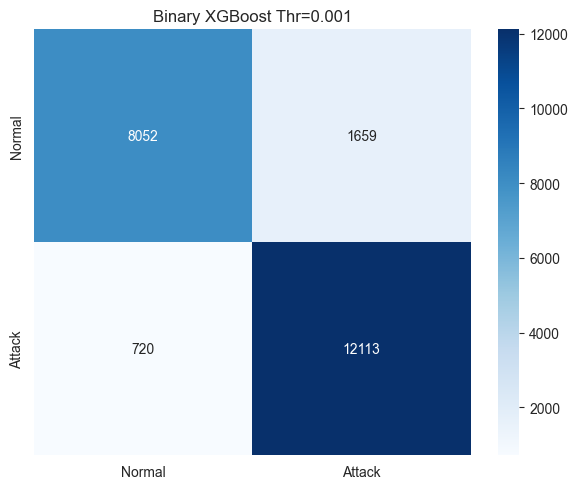

ROC-AUC: 0.9545
PR-AUC:  0.9515


In [19]:
# ----------------------------------------------------------------------
# Binary evaluation (TEST) + portability check
# ----------------------------------------------------------------------
print("\n🔎 PORTABILITY CHECK (RAW):")

def eval_at(th, y_true, y_proba):
    y_hat = (y_proba >= th).astype(int)
    return {
        "Precision": float(precision_score(y_true, y_hat, zero_division=0)),
        "Recall":    float(recall_score(y_true, y_hat, zero_division=0)),
        "PosRate":   float(y_hat.mean())
    }

test_probs = predict_proba_best_iter(final_binary_pipeline, X_test_full)

print(f"    THR Set: {eval_at(best_thr, y_thr, probs_thr)}")
print(f"    TEST:    {eval_at(best_thr, y_test_bin, test_probs)}")
print(f"    mean(test_probs)={test_probs.mean():.4f}  (diagnostic only)")

print("\n--- Classification Report (TEST) ---")
test_preds = (test_probs >= best_thr).astype(int)
print(classification_report(y_test_bin, test_preds, target_names=["Normal", "Attack"], digits=4))

cm = confusion_matrix(y_test_bin, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title(f"Binary XGBoost Thr={best_thr:.3f}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cm_binary.png")
plt.show()

print(f"ROC-AUC: {roc_auc_score(y_test_bin, test_probs):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test_bin, test_probs):.4f}")

# ==========================================
# 9. SIMULATION: Real-Time Dashboard Logic
# ==========================================


[3] Training Multi-class Model (Attacks Only)...

=== Multi-class TEST Results (Attacks Only) ===
              precision    recall  f1-score   support

         DoS     0.9741    0.8634    0.9154      7460
       Probe     0.5216    0.9318    0.6688      2421
         R2L     0.9710    0.6031    0.7441      2885
         U2R     0.3750    0.5821    0.4561        67

    accuracy                         0.8163     12833
   macro avg     0.7104    0.7451    0.6961     12833
weighted avg     0.8849    0.8163    0.8280     12833



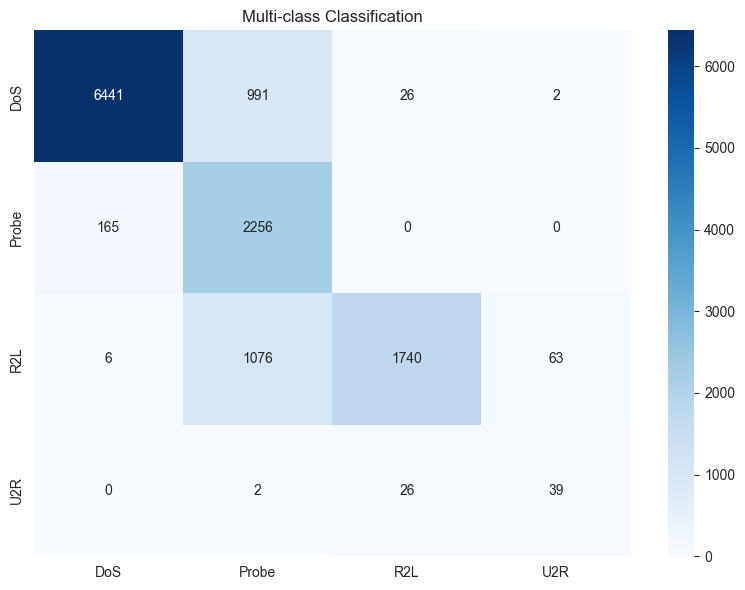


[4] Saving Artifacts...
[✓] Saved successfully.


In [ ]:
# ----------------------------------------------------------------------
# Multi-class model (Attacks only) + Save artifacts
# ----------------------------------------------------------------------
print("\n[3] Training Multi-class Model (Attacks Only)...")

train_attacks = train_df[train_df["attack_class"] != "Normal"]
test_attacks  = test_df[test_df["attack_class"]  != "Normal"]

X_train_multi = X_train_full.loc[train_attacks.index]
y_train_multi = train_attacks["attack_class"]
X_test_multi  = X_test_full.loc[test_attacks.index]
y_test_multi  = test_attacks["attack_class"]

multi_le = LabelEncoder()
y_train_enc = multi_le.fit_transform(y_train_multi)
y_test_enc  = multi_le.transform(y_test_multi)

prep_multi = copy.deepcopy(base_preprocessor)
xgb_multi = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

final_multi_pipeline = Pipeline([
    ("prep", prep_multi),
    ("model", xgb_multi)
])

classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
weight_dict = dict(zip(classes, weights))
sample_weights = np.array([weight_dict[y] for y in y_train_enc], dtype=float)

final_multi_pipeline.fit(X_train_multi, y_train_enc, model__sample_weight=sample_weights)

multi_preds = final_multi_pipeline.predict(X_test_multi)
print("\n=== Multi-class TEST Results (Attacks Only) ===")
print(classification_report(y_test_enc, multi_preds, target_names=multi_le.classes_, digits=4))

cm_multi = confusion_matrix(y_test_enc, multi_preds)
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', 
            xticklabels=multi_le.classes_, yticklabels=multi_le.classes_) 
plt.title("Multi-class Classification") 
plt.tight_layout() 
plt.savefig(FIGURES_DIR / "cm_multi.png") 
plt.show()

print("\n[4] Saving Artifacts...")
joblib.dump(final_binary_pipeline, MODELS_DIR / "binary_model.pkl")
joblib.dump(final_multi_pipeline,  MODELS_DIR / "multi_model.pkl")
joblib.dump(multi_le,              MODELS_DIR / "multi_label_encoder.pkl")

metadata = {
    "feature_columns": FEATURE_COLUMNS,
    "binary_threshold": float(best_thr),
    "threshold_strategy": {
        "type": "MaxF2_PosRateBand",
        "beta": 2.0,
        "posrate_band": [LOW_PR, HIGH_PR],
        "thr_floor": float(thr_floor)
    },
    "binary_model_best_iteration": int(final_binary_pipeline.named_steps["model"].best_iteration),
    "classes_multi": list(multi_le.classes_),
    "generated_at": time.strftime("%Y-%m-%d %H:%M:%S")
}
with open(MODELS_DIR / "model_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("[✓] Saved successfully.")